In [1]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


2023-03-21 23:22:31.045928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 23:22:31.113985: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TARGET_BYTE = 0 #何バイト目を攻撃するか決める

In [3]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [4]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [5]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [6]:
train_trace = train_trace[0:45000, 30824:31524]
test_trace = test_trace[45000:50000, 30824:31524]
attack_trace = attack_trace[50000:60000, 30824:31524]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [7]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [8]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [9]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [10]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [11]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [12]:
cnn_best()

2023-03-21 23:22:38.301946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 23:22:38.303208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 23:22:38.303275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 23:22:38.303577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [13]:
model=cnn_best(classes=256,input_dim=700)
epochs=10
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

Epoch 1/10


2023-03-21 23:22:40.096467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 23:22:41.426548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 23:22:41.503458: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcf0e228f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 23:22:41.503473: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-03-21 23:22:41.505710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 23:22:41.560729: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

225/225 [==============================] - 19s 67ms/step - loss: 5.5450 - accuracy: 0.0046 - val_loss: 5.5447 - val_accuracy: 0.0050
Epoch 2/10
225/225 [==============================] - 15s 67ms/step - loss: 5.5438 - accuracy: 0.0063 - val_loss: 5.5439 - val_accuracy: 0.0072
Epoch 3/10
225/225 [==============================] - 15s 67ms/step - loss: 5.5421 - accuracy: 0.0077 - val_loss: 5.5424 - val_accuracy: 0.0072
Epoch 4/10
225/225 [==============================] - 15s 67ms/step - loss: 5.5376 - accuracy: 0.0083 - val_loss: 5.5362 - val_accuracy: 0.0092
Epoch 5/10
225/225 [==============================] - 15s 67ms/step - loss: 5.5122 - accuracy: 0.0098 - val_loss: 5.4678 - val_accuracy: 0.0114
Epoch 6/10
225/225 [==============================] - 15s 67ms/step - loss: 5.2247 - accuracy: 0.0146 - val_loss: 4.9637 - val_accuracy: 0.0164
Epoch 7/10
225/225 [==============================] - 15s 68ms/step - loss: 4.7533 - accuracy: 0.0254 - val_loss: 4.5860 - val_accuracy: 0.0320
Epo

In [14]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

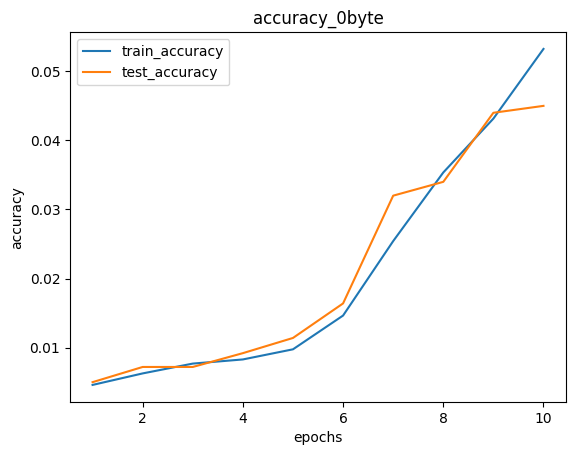

In [15]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [16]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [17]:
attack_plain=attack_metadata['plaintext']

In [18]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [19]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [20]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

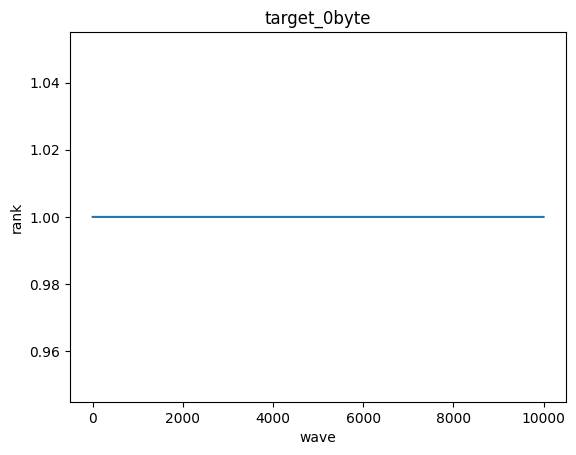

In [21]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [22]:
recovered_key0=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count0 = 1
        else:
            count0 = 0
        
        recovered_key0.append(count0) #攻撃成功バイト数の保存

recovered_key0 = np.array(recovered_key0)
np.save('./'+out+'/test0.npy', recovered_key0)

In [ ]:
TARGET_BYTE = 1 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 24577:25277]
test_trace = test_trace[45000:50000, 24577:25277]
attack_trace = attack_trace[50000:60000, 24577:25277]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=10
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key1=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count1 = 1
        else:
            count1 = 0
        
        recovered_key1.append(count1) #攻撃成功バイト数の保存

recovered_key1 = np.array(recovered_key1)
np.save('./'+out+'/test1.npy', recovered_key1)

In [ ]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


In [ ]:
TARGET_BYTE = 2 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 45400:46100]
test_trace = test_trace[45000:50000, 45400:46100]
attack_trace = attack_trace[50000:60000, 45400:46100]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=106
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key2=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count2 = 1
        else:
            count2 = 0
        
        recovered_key2.append(count2) #攻撃成功バイト数の保存

recovered_key2 = np.array(recovered_key2)
np.save('./'+out+'/test2.npy', recovered_key2)

In [ ]:
TARGET_BYTE = 3 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace.shape

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
train_trace = train_trace[0:45000, 32906:33606]
test_trace = test_trace[45000:50000, 32906:33606]
attack_trace = attack_trace[50000:60000, 32906:33606]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=178
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key3=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count3 = 1
        else:
            count3 = 0
        
        recovered_key3.append(count3) #攻撃成功バイト数の保存

recovered_key3 = np.array(recovered_key3)
np.save('./'+out+'/test3.npy', recovered_key3)

In [ ]:
TARGET_BYTE = 4 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace.shape

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
train_trace = train_trace[0:45000, 47482:48182]
test_trace = test_trace[45000:50000, 47482:48182]
attack_trace = attack_trace[50000:60000, 47482:48182]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
cnn_best()

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=101
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key4=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count4 = 1
        else:
            count4 = 0
        
        recovered_key4.append(count4) #攻撃成功バイト数の保存

recovered_key4 = np.array(recovered_key4)
np.save('./'+out+'/test4.npy', recovered_key4)

In [ ]:
TARGET_BYTE = 5 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 41235:41935]
test_trace = test_trace[45000:50000, 41235:41935]
attack_trace = attack_trace[50000:60000, 41235:41935]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=184
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key5=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count5 = 1
        else:
            count5 = 0
        
        recovered_key5.append(count5) #攻撃成功バイト数の保存

recovered_key5 = np.array(recovered_key5)
np.save('./'+out+'/test5.npy', recovered_key5)

In [ ]:
TARGET_BYTE = 6 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 37071:37771]
test_trace = test_trace[45000:50000, 37071:37771]
attack_trace = attack_trace[50000:60000, 37071:37771]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=92
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key6=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count6 = 1
        else:
            count6 = 0
        
        recovered_key6.append(count6) #攻撃成功バイト数の保存

recovered_key6 = np.array(recovered_key6)
np.save('./'+out+'/test6.npy', recovered_key6)

In [ ]:
TARGET_BYTE = 7 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 34989:35689]
test_trace = test_trace[45000:50000, 34989:35689]
attack_trace = attack_trace[50000:60000, 34989:35689]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=196
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key7=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count7 = 1
        else:
            count7 = 0
        
        recovered_key7.append(count7) #攻撃成功バイト数の保存

recovered_key7 = np.array(recovered_key7)
np.save('./'+out+'/test7.npy', recovered_key7)

In [ ]:
TARGET_BYTE = 8 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 26660:27360]
test_trace = test_trace[45000:50000, 26660:27360]
attack_trace = attack_trace[50000:60000, 26660:27360]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=68
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key8=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count8 = 1
        else:
            count8 = 0
        
        recovered_key8.append(count8) #攻撃成功バイト数の保存

recovered_key8 = np.array(recovered_key8)
np.save('./'+out+'/test8.npy', recovered_key8)

In [ ]:
TARGET_BYTE = 9 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 39154:39854]
test_trace = test_trace[45000:50000, 39154:39854]
attack_trace = attack_trace[50000:60000, 39154:39854]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=64
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key9=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count9 = 1
        else:
            count9 = 0
        
        recovered_key9.append(count9) #攻撃成功バイト数の保存

recovered_key9 = np.array(recovered_key9)
np.save('./'+out+'/test9.npy', recovered_key9)

In [ ]:
TARGET_BYTE = 10 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 28742:29442]
test_trace = test_trace[45000:50000, 28742:29442]
attack_trace = attack_trace[50000:60000, 28742:29442]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=195
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key10=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count10 = 1
        else:
            count10 = 0
        
        recovered_key10.append(count10) #攻撃成功バイト数の保存

recovered_key10 = np.array(recovered_key10)
np.save('./'+out+'/test10.npy', recovered_key10)

In [ ]:
TARGET_BYTE = 11 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 43318:44018]
test_trace = test_trace[45000:50000, 43318:44018]
attack_trace = attack_trace[50000:60000, 43318:44018]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=115
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key11=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count11 = 1
        else:
            count11 = 0
        
        recovered_key11.append(count11) #攻撃成功バイト数の保存

recovered_key11 = np.array(recovered_key11)
np.save('./'+out+'/test11.npy', recovered_key11)

In [ ]:
TARGET_BYTE = 12 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 20413:21113]
test_trace = test_trace[45000:50000, 20413:21113]
attack_trace = attack_trace[50000:60000, 20413:21113]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=171
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key12=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count12 = 1
        else:
            count12 = 0
        
        recovered_key12.append(count12) #攻撃成功バイト数の保存

recovered_key12 = np.array(recovered_key12)
np.save('./'+out+'/test12.npy', recovered_key12)

In [ ]:
TARGET_BYTE = 13 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 22495:23195]
test_trace = test_trace[45000:50000, 22495:23195]
attack_trace = attack_trace[50000:60000, 22495:23195]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=100
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key13=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count13 = 1
        else:
            count13 = 0
        
        recovered_key13.append(count13) #攻撃成功バイト数の保存

recovered_key13 = np.array(recovered_key13)
np.save('./'+out+'/test13.npy', recovered_key13)

In [ ]:
TARGET_BYTE = 14 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 49565:50265]
test_trace = test_trace[45000:50000, 49565:50265]
attack_trace = attack_trace[50000:60000, 49565:50265]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=78
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key14=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count14 = 1
        else:
            count14 = 0
        
        recovered_key14.append(count14) #攻撃成功バイト数の保存

recovered_key14 = np.array(recovered_key14)
np.save('./'+out+'/test14.npy', recovered_key14)

In [ ]:
TARGET_BYTE = 15 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
train_trace = train_trace[0:45000, 18330:19030]
test_trace = test_trace[45000:50000, 18330:19030]
attack_trace = attack_trace[50000:60000, 18330:19030]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
cnn_best()

In [ ]:
model=cnn_best(classes=256,input_dim=700)
epochs=158
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

In [ ]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

In [ ]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の1000を攻撃に使用

In [ ]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [ ]:
recovered_key15=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count15 = 1
        else:
            count15 = 0
        
        recovered_key15.append(count15) #攻撃成功バイト数の保存

recovered_key15 = np.array(recovered_key15)
np.save('./'+out+'/test15.npy', recovered_key15)

In [6]:
from matplotlib.ticker import MaxNLocator

(0.0, 17.0)

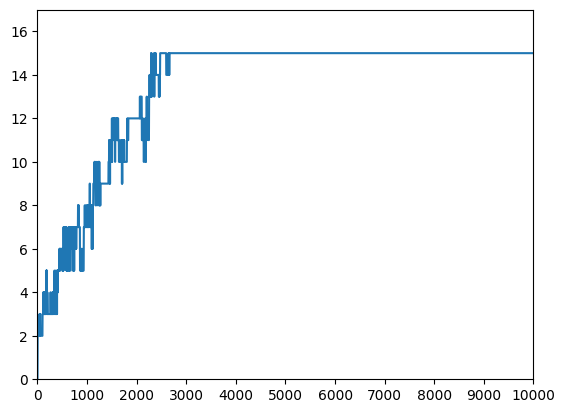

In [7]:
recovered_key0 = np.load('test0.npy')
recovered_key1 = np.load('test1.npy')
recovered_key2 = np.load('test2.npy')
recovered_key3 = np.load('test3.npy')
recovered_key4 = np.load('test4.npy')
recovered_key5 = np.load('test5.npy')
recovered_key6 = np.load('test6.npy')
recovered_key7 = np.load('test7.npy')
recovered_key8 = np.load('test8.npy')
recovered_key9 = np.load('test9.npy')
recovered_key10 = np.load('test10.npy')
recovered_key11 = np.load('test11.npy')
recovered_key12 = np.load('test12.npy')
recovered_key13 = np.load('test13.npy')
recovered_key14 = np.load('test14.npy')
recovered_key15 = np.load('test15.npy')

A = recovered_key0 + recovered_key1 + recovered_key2 + recovered_key3 + recovered_key4 + recovered_key5 + recovered_key6 + recovered_key7 + recovered_key8 + recovered_key9 + recovered_key10 + recovered_key11 + recovered_key12 + recovered_key13 + recovered_key14 + recovered_key15
fig, ax = plt.subplots()
ax.plot(A)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim(0, 10000)
plt.ylim(0, 17)